<a href="https://colab.research.google.com/github/mgjehrio/projects/blob/main/Copy_of_AIMDatathon_PatientSurvival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

## Set the appropriate directory.

In [ ]:
%cd /content/drive/My Drive/aimdatathon2020

/content/drive/My Drive/aimdatathon2020


##There was a train and test dataset, along with 17 accompanying datasets. Here we merge them.

In [ ]:
import pandas as pd
import os

train = pd.read_csv('Tumor Information_train.csv')
test = pd.read_csv('Tumor Information_test.csv')

train.columns = map(str.lower, train.columns)
test.columns = map(str.lower, test.columns)

file_list = os.listdir()
file_list.remove('Tumor Information_train.csv')
file_list.remove('Tumor Information_test.csv')
file_list.remove('DBBR Questionnaire Data Dictionary.csv')

print(file_list)

for data in file_list:
  train = train.merge(pd.read_csv(data).rename(columns=str.lower), on='qbarcode', how='left')
  test = test.merge(pd.read_csv(data).rename(columns=str.lower), on='qbarcode', how='left')

all_data = pd.concat([train, test])

['Beverages.csv', 'Current Lifestyle.csv', 'Family History.csv', 'Exercise.csv', 'Food Habits.csv', 'Background and Helpful Info.csv', 'MedicationUseHistory.csv', 'Lifetime use of Supplements.csv', 'Nutrient Calc.csv', 'Herbals.csv', 'Foods.csv', 'Smoking History.csv', 'MedicalHistory.csv', 'Multivitamins.csv', 'Vitamins Minerals.csv', 'WomensHealth.csv']


##Exploratory Data Analysis

##We process the data by encoding categorical columns and filling NaN values with the mode of the feature. Notice how we do not normalize the data or check for multicollinearity. This will make sense very shortly. We also notice that there is mild class imbalance between the two categories.  

In [ ]:
from sklearn import preprocessing

cols = [col for col in all_data.columns if col not in ['patientstatus', 'qbarcode']]

types = all_data.dtypes
cat_columns = [t[0] for t in types.iteritems() if ((t[1] not in ['int64', 'float64']))]

lbl = preprocessing.LabelEncoder()
for col in cat_columns:
    all_data[col] = lbl.fit_transform(all_data[col].astype(str))

all_data = all_data.fillna(all_data.mode().iloc[0])


train_processed_data = all_data.iloc[:len(train)]
test_processed_data = all_data.iloc[len(train):]

print('Below are the shapes of our of our train and test sets:')
print('Train:', train_processed_data.shape)
print('Test:', test_processed_data.shape)

print('The frequencies of each class:')
print(train['patientstatus'].value_counts())

Below are the shapes of our of our train and test sets:
Train: (1600, 1214)
Test: (400, 1214)
The frequencies of each class:
1    996
0    604
Name: patientstatus, dtype: int64


# Model choice and train-validation split

##Import the necessary machine learning models. Since we have a classification task with structured data, XGBoost is a safe bet with proven performance in industry.

##Decision trees do not require normalization of inputs, and since XGBoost is an ensemble of decision trees, this principle also applies here. XGBoost naturally deals with multicollinearity as well.

##Our test set does not have labels, so we have use a part of the training set as a validation set to assess our model's performance.

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

cols = [col for col in train_processed_data.columns if col not in ['patientstatus', 'qbarcode']]

train = train_processed_data[cols].values
labels = train_processed_data['patientstatus'].values

x_train, x_val, y_train, y_val = train_test_split(train, labels, test_size=0.2, random_state=42)

# Model training, tuning, and validation

##Set the model parameters, train the model, and evaluate it. The hyperparameters here were manually tuned and are optimal.

##We use accuracy and area under reciever operator characteristic curve values to get baseline numeric performance measures, and we then view the classification report to check for Type 1 and Type 2 error rates. 

In [ ]:
bst = xgb.XGBClassifier(max_depth=2, n_estimators=100, learning_rate=0.1, objective='reg:logistic', gamma=0, colsample_bytree=0.3)
bst.fit(x_train, y_train)
y_hat = bst.predict(x_val)
print('Accurary Score:', bst.score(x_val, y_val))
print('Area under ROC:', roc_auc_score(y_val, y_hat))
print(classification_report(y_val, y_hat))

Accurary Score: 0.775
Area under ROC: 0.7331800374723216
              precision    recall  f1-score   support

         0.0       0.73      0.59      0.65       114
         1.0       0.79      0.88      0.83       206

    accuracy                           0.78       320
   macro avg       0.76      0.73      0.74       320
weighted avg       0.77      0.78      0.77       320



##Plot the ROC curve.

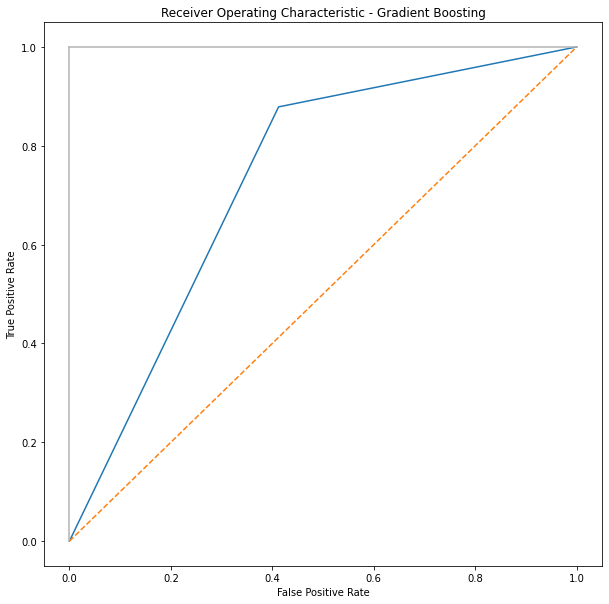

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, y_hat)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Model evaluation on test data

##Now we can make predictions on our unseen test data and view them patient-by-patient. Only the first 20 are shown.

In [ ]:
test= test_processed_data[cols].values
predictions = bst.predict(test)

out_df = pd.DataFrame(
        {"qbarcode": test_processed_data.qbarcode.values,
         "PatientStatus": predictions
        }
    )

print(out_df.head(20))

    qbarcode  PatientStatus
0        856            1.0
1       1759            1.0
2       2275            1.0
3       1407            1.0
4       1996            0.0
5      10961            0.0
6        264            1.0
7      16155            0.0
8       5183            0.0
9       3052            1.0
10     12893            1.0
11      2873            1.0
12      5178            1.0
13      5835            1.0
14      4330            1.0
15      3707            1.0
16     13348            0.0
17     15620            1.0
18       360            1.0
19      4578            1.0


##Create a submission file

In [ ]:
out_df.to_csv('submission_aim.csv', index=False)